# test 데이터
* 예측값을 만들어 workspace/data/train/test_pred.npy 파일로 추출됨
* 예측값의 히스토그램과 feature importance가 출력됨
* python broadcast.py로 최적의 편성표가 만들어지며 workspace/output/cast에 저장됨.

In [9]:
# 전처리 과정 : 파일이 생성됨
! pypthon processing_data.py
! python modeling.py config/model_setting.txt

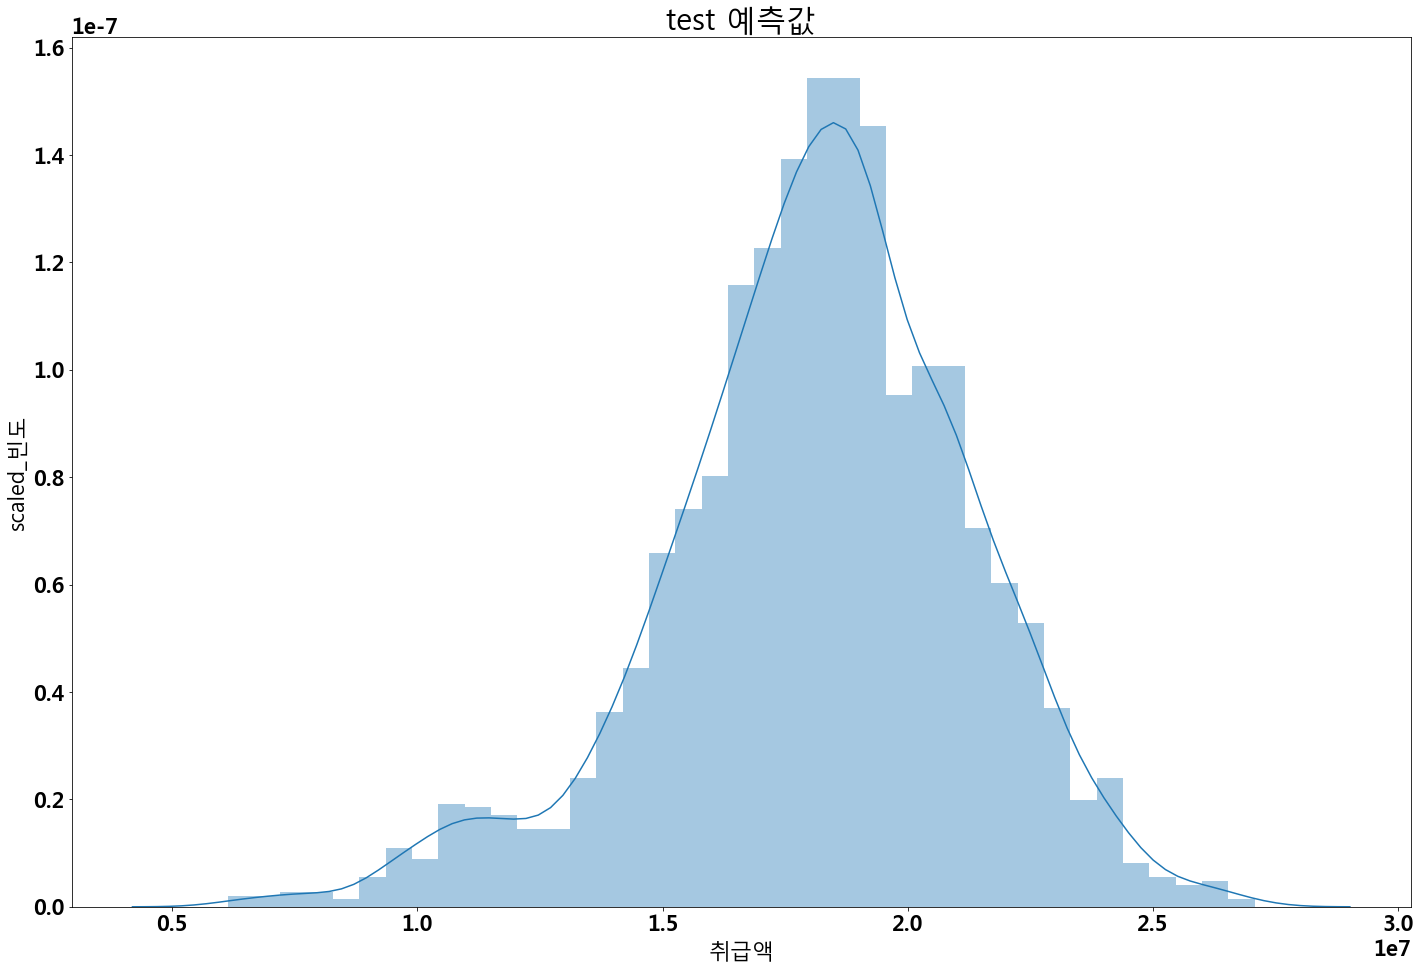

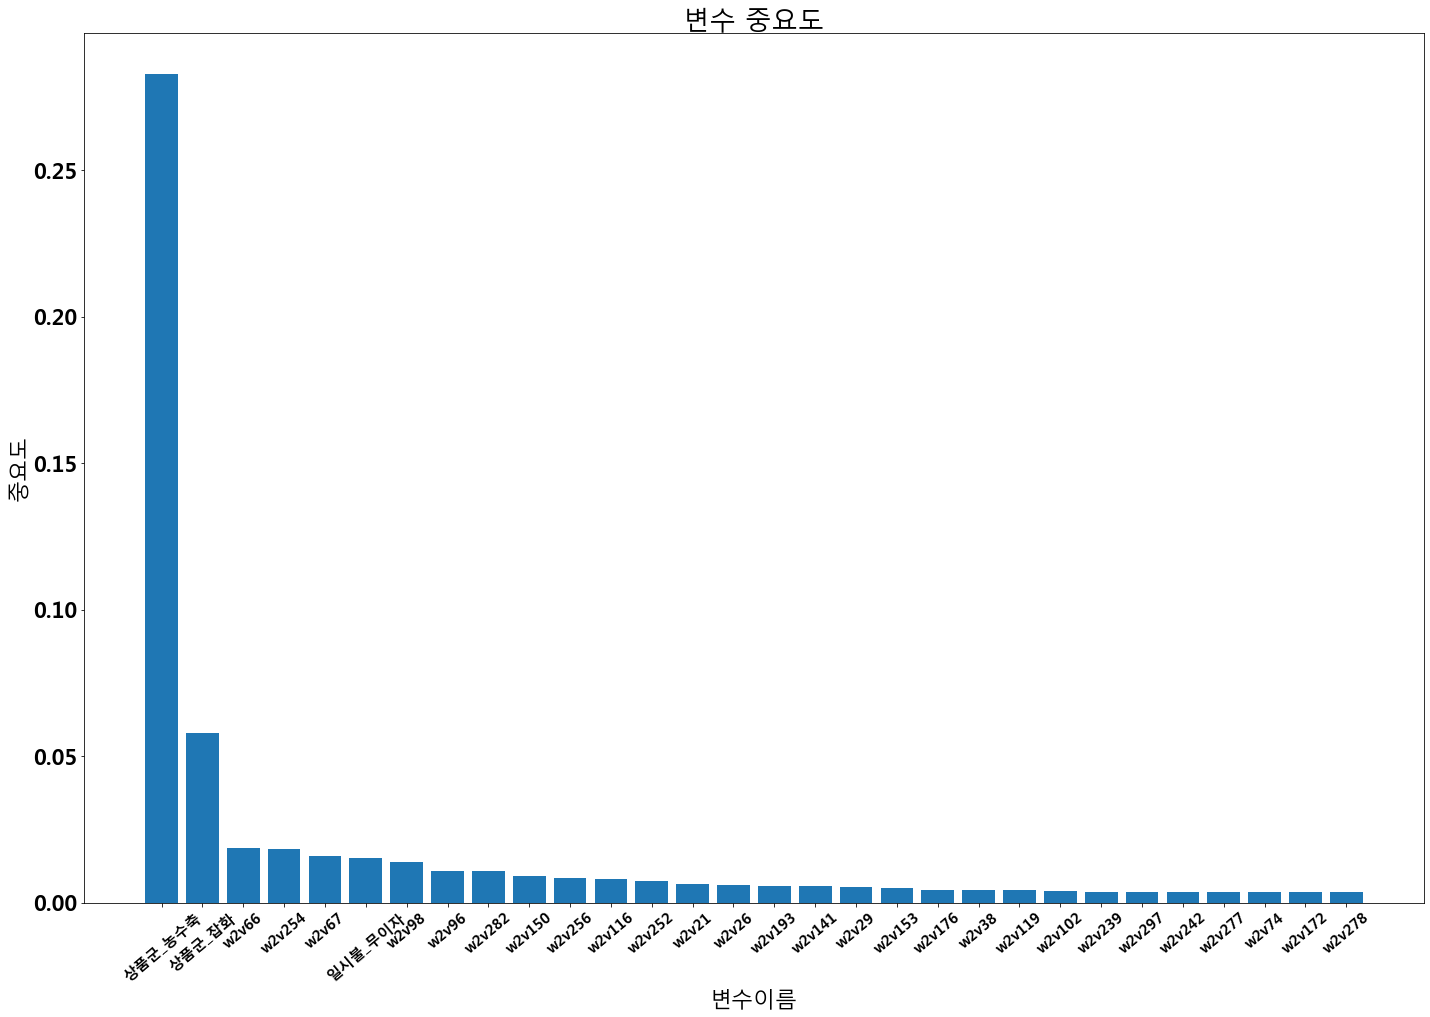

In [13]:
# 예측값 만들기 : test 데이터의 취급액 분포와 모델의 feature importance 그래프를 생성함
import matplotlib 
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import pandas as pd
import utils
import numpy as np
import pickle
import os
from load_data import load_data
import seaborn as sns


def make_product_key():         
    product_list = ['가구','가전','건강기능','농수축','생활용품',
                    '속옷','의류','이미용','잡화','주방','침구']
    product_dict = {'상품군_%s'%k : k for k in product_list}
    return product_dict


def make_season_key():         
    season_dict = {'계절_0':0,'계절_1':1,'계절_2':2,'계절_3':3}
    return season_dict

def make_month_key():
    month_dict = {'월_%s'%k : k for k in range(1,13)}
    return month_dict

def make_week_key():

    week_dict = {'주차_%s'%k : k for k in range(1,54)}
    return week_dict

def make_hour_key():

    hour_dict = {'시간대_%s'%k : k for k in [0,1,2,6,7,8,9,10,11,12,13,14,15,16,
                                          17,18,19,20,21,22,23]}
    return hour_dict


def make_not_enough_dummy(dummy_df, col):
    result_df = dummy_df.copy()
    element_list = np.unique(dummy_df['name'])
    for element in element_list:
        temp_col_name = '%s_%s'%(col,element)
        result_df[temp_col_name] = 0
        
        ind = dummy_df[dummy_df['name'] == element].index
        result_df.loc[ind,temp_col_name]  = 1
    
    if col == '계절':
        target_dict = make_season_key()
    elif col == '월':
        target_dict = make_month_key()
    elif col == '주차':
        target_dict = make_week_key()
    elif col == '상품군':
        target_dict = make_product_key()
    elif col == '시간대':
        target_dict = make_hour_key()
    for key in target_dict.keys():
        if key not in result_df.columns:
            result_df[key] = 0
    
    result_df = result_df.loc[:,['name']+[k for k in target_dict.keys()]]
    
    return result_df, target_dict
        


def make_dummy(df, col_name):
    #col_name = 'new_월'
    not_enough_col_list = ['월','주차','계절','상품군','시간대']
    dummy = pd.get_dummies(df[col_name], prefix=col_name)
    
    dummy_df = pd.DataFrame({'name':df[col_name]})
    dummy_df = pd.concat([dummy_df, dummy], axis=1)
    
    name_dict = {}
    for col in dummy_df.columns[1:]:
        target = dummy_df[dummy_df[col]!=0].reset_index(drop=True).loc[0,['name',col]]
        name_dict[col] = target['name']
    
    # 보충
    if col_name in not_enough_col_list:
        dummy_df, name_dict = make_not_enough_dummy(dummy_df, col_name) 
        
    col_stand_name = '_'.join(dummy_df.columns[1].split('_')[:-1])

    col_list = ['%s_%s'%(col_stand_name,v) for v in name_dict.values()]
    
    dummy_df = dummy_df.iloc[:,1:]
    dummy_df.columns = col_list

    df = df.drop(col_name, axis=1)
    df = pd.concat([df, dummy_df], axis=1)

    return df

def extract_dummy(X_data, save_path):
    
    # 더미변수 추출
    with open(save_path+'model_setting.txt', 'r') as f1:
        while True:
            line = f1.readline()
            if 'dummy' in line:
                dummy_var = line.split('=')[1]
            
            if not line:
                break
    
    dummy_list = dummy_var.split(',')
    dummy_list[-1] = dummy_list[-1][:-1]
    
    for col in dummy_list:
        X_data = make_dummy(X_data, col)
    
    return X_data



def load_x_col(save_path):

    with open(save_path+'test_result.pkl', 'rb') as f:
        obj_dict = pickle.load(f)
    
    x_col = obj_dict['result']['data']['changed_x_col']
    
    return x_col

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

fm.get_fontconfig_fonts()
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rc('font', family='Malgun Gothic')

model_path = utils.model_path

train_path = utils.train_path
fig_path = utils.fig_path
#%%
def load_model(save_path):
    # 0. 최적 모델 가져오기
    
    with open(save_path+'test_result.pkl', 'rb') as f:
        result = pickle.load(f)
        
    return result


def predict_value(X_data, save_path):
    # 모델
    result = load_model(save_path)

    # 예측값 구하기
    pred_list = []
    X_data = extract_dummy(X_data, save_path)
    x_col = load_x_col(save_path)
    X_data = X_data.loc[:,x_col]
    X_data = X_data.fillna(0)
    X_data = X_data.values
    
    for i in range(5):
        valid_ind = result['result']['data']['dataset']['valid'][i]

        with open(save_path+'model_%s.pkl'%(i), 'rb') as f:
            model = pickle.load(f)
        pred = model.predict(X_data).reshape(-1,)
        pred_list.append(pred)
    
    pred_list = np.mean(np.stack(pred_list),axis=0)
    
    plt.figure(figsize=(24,16))
    sns.distplot(pred_list)
    plt.title('test 예측값', size=30)
    plt.xlabel('취급액')
    plt.ylabel('scaled_빈도')

    plt.savefig(fig_save_path+'test 데이터 분포.png')
    plt.show()
    
    return pred_list


def extract_feature_importance(save_path, fig_save_path, fig_save_option=False):

    result = load_model(save_path)    

    x_col = result['result']['data']['changed_x_col']
    
    feature_df = pd.DataFrame({'x_col':x_col})
    for i in range(5):
        feature = result['result']['feature'][i]
        feature_df[i] = feature
        
    feature_df['important'] = np.mean(feature_df.iloc[:,1:],axis=1)
    feature_df = feature_df[['x_col','important']]
    feature_df = feature_df.sort_values('important',ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(24,16))
    plt.bar(feature_df.loc[:29,'x_col'], feature_df.loc[:29,'important'])
    plt.title('변수 중요도')
    plt.ylabel('중요도')
    plt.xlabel('변수이름')
    plt.xticks(rotation=40, size=15)
    if fig_save_option == True:
        plt.savefig(fig_save_path+'변수 중요도.png')
    plt.show()
    
    return 0

def main(save_path = model_path+'xgb_bds100/'):
    # 1. 파일 불러오기
    train = load_data('train.csv', 'train_WordVec.pkl', True)
    test = load_data('test.csv', 'test_WordVec.pkl',True)
    
    # 예측값 추출
    y_pred = predict_value(test, save_path)
    
    # 저장
    np.save(train_path+'test_pred.npy',y_pred)
    
    # feature_importance
    extract_feature_importance(save_path, fig_path+'모델/', fig_save_option=True)

main()

In [14]:
# 최적 편성표 만듦 : output/cast에 저장됨
! python broadcast.py

^C
